In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



import os
import glob
import fnmatch
import re


## Read Arapuca run log 

In [2]:
df_Xerunlist = pd.read_csv('./XeArapucaRunList.csv', sep = ';')
df_Xerunlist.head()

,Run Number,Config,Day/time,Comments,Efield
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False
2,10874,CRT_noprescale_delay_Feb00003,06/02/2020,"Biases for channels 0,6 and 8 to 11 of SSP 504...",False
3,10875,CRT_noprescale_delay_Feb00003,06/02/2020,Biases for channels 0 to 7 of SSP 504 brought ...,False
4,10877,XeDope_CRT_noprescale_delay_Feb00002,06/02/2020,New config with lower disc thresholds (70 ADC ...,False


In [15]:
## add tiem infos
df_Xetimelist = pd.read_csv('./timeinfos.txt', sep = '\t', header=None, names={'Run Number', 'daytime'})

df_Xetimelist['daytime'] = pd.to_datetime(df_Xetimelist['daytime'])
#df_Xetimelist['day'] = pd.to_datetime(df_Xetimelist['daytime']).dt.date
#df_Xetimelist['time'] = pd.to_datetime(df_Xetimelist['daytime']).dt.time
df_Xetimelist.head()

,Run Number,daytime
0,10872,2020-02-06 13:51:48+00:00
1,10873,2020-02-06 14:03:28+00:00
2,10874,2020-02-06 14:25:00+00:00
3,10875,2020-02-06 15:38:58+00:00
4,10877,2020-02-06 16:06:42+00:00


In [13]:
df_tmp = pd.merge(df_Xerunlist, df_Xetimelist, how = 'inner', on=['Run Number'])
df_tmp.head(2)

,Run Number,Config,Day/time,Comments,Efield,daytime,day,time
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False,2020-02-06 13:51:48+00:00,2020-02-06,13:51:48
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False,2020-02-06 14:03:28+00:00,2020-02-06,14:03:28


In [16]:
df_Xerunlist_info = df_tmp[['Run Number', 'Day/time', 'daytime', 'Efield']]
df_Xerunlist_info['Day/time'] = pd.to_datetime(df_Xerunlist_info['Day/time'], format='%d/%m/%Y')
df_Xerunlist_info['Day/time'] = df_Xerunlist_info['Day/time'].dt.strftime('%d %b')
df_Xerunlist_info.head()

,Run Number,Day/time,daytime,Efield
0,10872,06 Feb,2020-02-06 13:51:48+00:00,False
1,10873,06 Feb,2020-02-06 14:03:28+00:00,False
2,10874,06 Feb,2020-02-06 14:25:00+00:00,False
3,10875,06 Feb,2020-02-06 15:38:58+00:00,False
4,10877,06 Feb,2020-02-06 16:06:42+00:00,False


## Read my files and do the analysis

In [17]:
# read APA 6 files 

base_path_mod603 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603'
file_path_mod603 = os.path.join(base_path_mod603,'CalibratedIntegral_*.csv')

file_name_list_mod603 =  glob.glob(file_path_mod603) 
print(' Getting infos from ', len(file_name_list_mod603), 'runs ')

Getting infos from  51 runs 


In [18]:
# read APA 3 files 

base_path_mod304 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304'
file_path_mod304 = os.path.join(base_path_mod304,'CalibratedIntegral_*.csv')

file_name_list_mod304 =  glob.glob(file_path_mod304) 
print(' Getting infos from ', len(file_name_list_mod304), 'runs ')

Getting infos from  74 runs 


In [19]:
def readfile_list(filename_list):       
    
    def read_single_file(f):
        data = pd.read_csv(f, index_col=0)
        return data
    
    data_list = [read_single_file(f) for f in filename_list]
    return pd.concat(data_list, axis=0)

In [20]:
df_603 = readfile_list(file_name_list_mod603)
df_603.head()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,5534.322105,438.797034,144.886754,1.000000,6804
1,11021,1,14117.131841,450.359705,152.530278,1.026351,2504
2,11021,2,13022.030469,448.850498,143.627997,1.022911,2385
3,11021,3,15045.207965,415.431604,156.352321,0.946751,2247
4,11021,4,7202.065870,444.835992,145.092221,1.013763,6747


In [21]:
df_304 = readfile_list(file_name_list_mod304)
df_304.head()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,7554.093236,475.629607,164.225912,1.000000,10620
1,11021,1,5965.158716,473.798684,163.436650,0.996151,10694
2,11021,2,6811.382174,478.290037,163.970221,1.005593,10659
3,11021,3,5707.479941,491.526595,165.134200,1.033423,10700
4,11021,4,13929.721287,477.829584,163.054736,1.004625,4830


In [22]:
#create df apa6 for the integral

df_integral_603 = df_603.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_603.groupby(['Run number'])['n good evts'].sum())
df_integral_603['stat err'] = stat.values
df_integral_603.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_603.head()

,Run Number,Integral,stat err
0,10906,117264.588563,80.901174
1,10907,136793.434553,125.582642
2,10909,127661.812705,76.111760
3,10912,169646.176015,52.640289
4,10915,167335.857995,54.304696


In [23]:
df_apa6 = pd.merge(df_Xerunlist_info, df_integral_603, how = 'inner', on=['Run Number'])
df_apa6.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10906,09 Feb,2020-02-09 09:38:25+00:00,False,117264.588563,80.901174
1,10907,09 Feb,2020-02-09 13:08:44+00:00,False,136793.434553,125.582642
2,10909,09 Feb,2020-02-09 20:41:41+00:00,False,127661.812705,76.111760
3,10915,10 Feb,2020-02-10 08:53:11+00:00,False,167335.857995,54.304696
4,10922,10 Feb,2020-02-10 15:40:03+00:00,False,140715.673310,38.223030


In [24]:
#create df apa3 for the integral

df_integral_304 = df_304.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_304.groupby(['Run number'])['n good evts'].sum())
df_integral_304['stat err'] = stat.values
df_integral_304.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_304.head()

,Run Number,Integral,stat err
0,10877,143112.006752,167.263266
1,10878,134258.434941,177.208916
2,10879,146913.710598,163.000000
3,10885,138948.518489,142.635900
4,10903,142025.626576,163.187009


In [25]:
df_apa3 = pd.merge(df_Xerunlist_info, df_integral_304, how = 'inner', on=['Run Number'])
df_apa3.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [26]:
# check if there are runs with EField ON
print(' Checking if there are runs for APA6  with Efield ON : ' )
display(df_apa6['Efield'].value_counts() )

print(' Checking if there are runs for APA3  with Efield ON : ' )
display(df_apa3['Efield'].value_counts() )

df_apa6_efieldON = df_apa6.loc[(df_apa6['Efield'] ==True)]
#display(df_apa6_efieldON.shape)

df_apa6_efieldOFF = df_apa6.loc[(df_apa6['Efield'] ==False)]

df_apa3_efieldON = df_apa3.loc[(df_apa3['Efield'] ==True)]
df_apa3_efieldOFF = df_apa3.loc[(df_apa3['Efield'] ==False)]




Checking if there are runs for APA6  with Efield ON : 


False    42
Name: Efield, dtype: int64

Checking if there are runs for APA3  with Efield ON : 


False    63
True      4
Name: Efield, dtype: int64

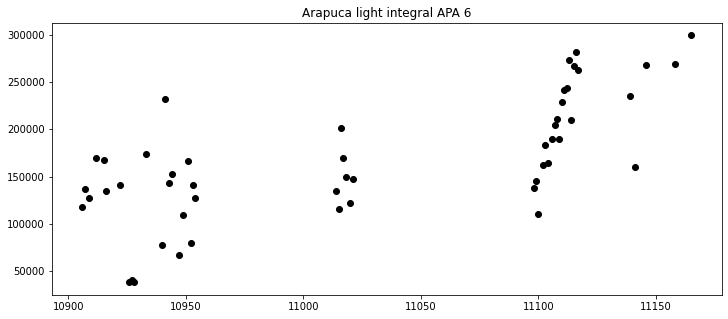

In [27]:
plt.figure(figsize=(12,5))

plt.title('Arapuca light integral APA 6')
plt.errorbar(x=df_integral_603['Run Number'], y=df_integral_603['Integral'], yerr=df_integral_603['stat err'], 
            fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
plt.show()

            

## Plot APA 3 and APA 6 integrals as a function of the time

In [ ]:
import matplotlib.patches as patches

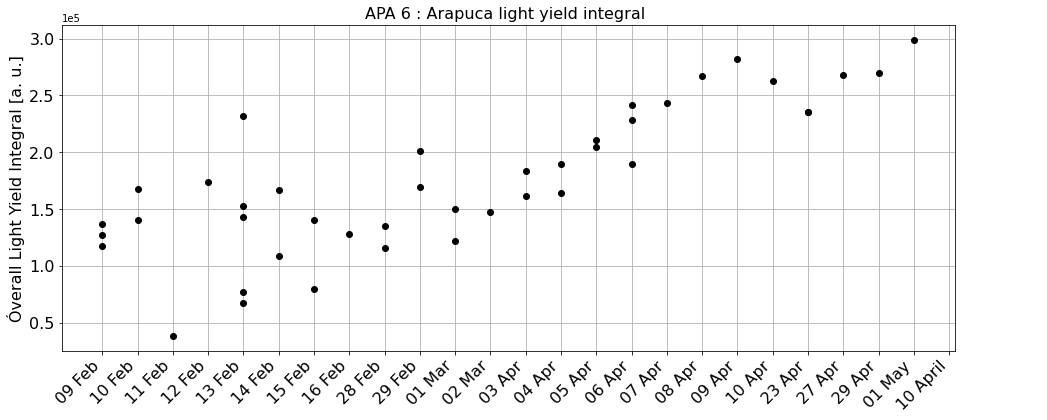

In [28]:
############################################################
#                           APA 6 
############################################################
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

plt.title('APA 6 : Arapuca light yield integral ', fontsize=16)
plt.errorbar(x=df_apa6_efieldOFF['Day/time'], y=df_apa6_efieldOFF['Integral'], yerr=np.sqrt(df_apa6_efieldOFF['stat err']), fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

plt.ylabel('Óverall Light Yield Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

ax.annotate('Preliminary', xytext=('10 April', 0.5), xy=('10 April', 0.5), fontsize = 16 )

plt.grid()
plt.show()
fig.savefig('./Integral_A_apa6.pdf')

In [142]:
df_apa3_efieldOFF.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


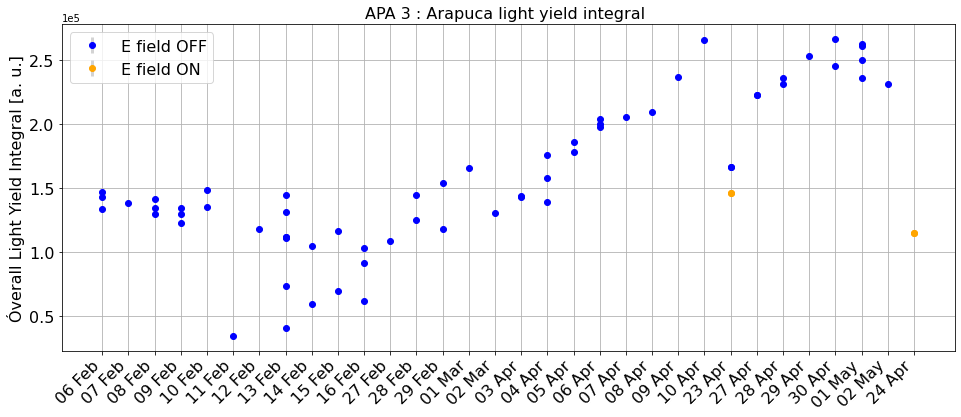

In [143]:
############################################################
#                           APA 3 
############################################################
fig = plt.figure(figsize=(16,6))

plt.title('APA 3 : Arapuca light yield integral ', fontsize=16)
plt.errorbar(x=df_apa3_efieldOFF['Day/time'], y=df_apa3_efieldOFF['Integral'], yerr=np.sqrt(df_apa3_efieldOFF['stat err']), fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')

plt.errorbar(x=df_apa3_efieldON['Day/time'], y=df_apa3_efieldON['Integral'], yerr=np.sqrt(df_apa3_efieldON['stat err']), fmt='o', color='orange', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field ON')


plt.ylabel('Óverall Light Yield Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()
fig.savefig('./Integral_A_apa3.pdf')


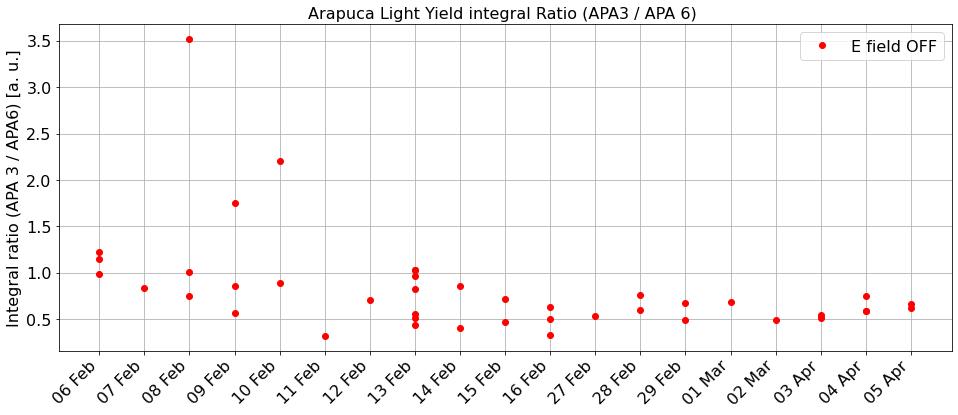

In [144]:
############################################################
#                           RATIO APA 6 / APA 3 
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('Arapuca Light Yield integral Ratio (APA3 / APA 6) ', fontsize=16)
plt.errorbar(x=df_apa3_efieldOFF['Day/time'], y=df_apa3_efieldOFF['Integral']/df_apa6_efieldOFF['Integral'], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')



plt.ylabel('Integral ratio (APA 3 / APA6) [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()
fig.savefig('./ratio_A_apa3vsapa6.pdf')




In [145]:
df_ratio_apas = pd.merge(df_apa6_efieldOFF, df_apa3_efieldOFF, how = 'inner', on=['Run Number', 'Day/time'], suffixes=('_APA6', '_APA3'))
df_ratio_apas.head()

,Run Number,Day/time,daytime_APA6,Efield_APA6,Integral_APA6,stat err_APA6,daytime_APA3,Efield_APA3,Integral_APA3,stat err_APA3
0,10906,09 Feb,2020-02-09 09:38:25+00:00,False,117264.588563,80.901174,2020-02-09 09:38:25+00:00,False,134789.696363,173.458929
1,10907,09 Feb,2020-02-09 13:08:44+00:00,False,136793.434553,125.582642,2020-02-09 13:08:44+00:00,False,130298.453004,168.083313
2,10909,09 Feb,2020-02-09 20:41:41+00:00,False,127661.812705,76.111760,2020-02-09 20:41:41+00:00,False,123302.346623,193.514857
3,10915,10 Feb,2020-02-10 08:53:11+00:00,False,167335.857995,54.304696,2020-02-10 08:53:11+00:00,False,135826.550504,165.254349
4,10922,10 Feb,2020-02-10 15:40:03+00:00,False,140715.673310,38.223030,2020-02-10 15:40:03+00:00,False,148478.395055,55.127126


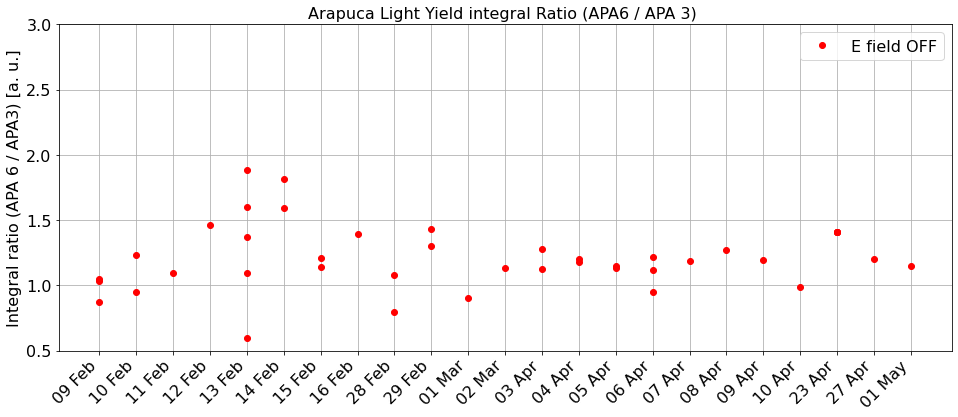

In [146]:
############################################################
#                           RATIO APA 6 / APA 3 
############################################################


fig = plt.figure(figsize=(16,6))

plt.title('Arapuca Light Yield integral Ratio (APA6 / APA 3) ', fontsize=16)
#plt.errorbar(x=df_apa6_efieldOFF['Day/time'], y=df_apa6_efieldOFF['Integral']/df_apa3_efieldOFF['Integral'], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')

plt.errorbar(x=df_ratio_apas['Day/time'], y=df_ratio_apas['Integral_APA6']/df_ratio_apas['Integral_APA3'], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')



plt.ylabel('Integral ratio (APA 6 / APA3) [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)
plt.ylim((0.5, 3))

plt.legend(fontsize=16)

plt.grid()
plt.show()
fig.savefig('./ratio_A_apa6vsapa3.pdf')


## Do plots against X-Arapuca

In [147]:
df_XA = pd.read_csv('./XArapuca_IntegralsSPE.txt', sep= ' ', header=None, index_col=0, names=['W/O quartz', 'W quartz', 'Date', 'Time'])

df_XA['Date'] = pd.to_datetime(df_XA['Date'], format='%Y:%m:%d')
df_XA['Date'] = df_XA['Date'].dt.strftime('%d %b')

df_XA.head()

,W/O quartz,W quartz,Date,Time
0,39.4964,3.66560,13 Feb,18:40:27
1,50.4461,7.94902,13 Feb,18:45:23
2,106.6290,10.26250,13 Feb,18:48:59
3,154.1550,24.46120,13 Feb,19:05:00
4,102.9690,18.79770,13 Feb,19:27:47


In [148]:
# create data frame with both XA infos and APA 3 (APA 6)

df_XA_vs_APA3 = pd.merge(df_XA, df_apa3, how = 'inner', left_on=['Date'], right_on='Day/time')

df_XA_vs_APA6 = pd.merge(df_XA, df_apa6, how = 'inner', left_on=['Date'], right_on='Day/time')


df_XA_vs_APA6.head()


,W/O quartz,W quartz,Date,Time,Run Number,Day/time,daytime,Efield,Integral,stat err
0,39.4964,3.6656,13 Feb,18:40:27,10940,13 Feb,13 Feb : 10 AM,False,77186.889488,64.892218
1,39.4964,3.6656,13 Feb,18:40:27,10941,13 Feb,13 Feb : 11 AM,False,232205.079817,33.361655
2,39.4964,3.6656,13 Feb,18:40:27,10943,13 Feb,13 Feb : 02 PM,False,143452.746462,37.881394
3,39.4964,3.6656,13 Feb,18:40:27,10944,13 Feb,13 Feb : 02 PM,False,152623.571707,52.163205
4,39.4964,3.6656,13 Feb,18:40:27,10947,13 Feb,13 Feb : 06 PM,False,67262.557810,91.279790


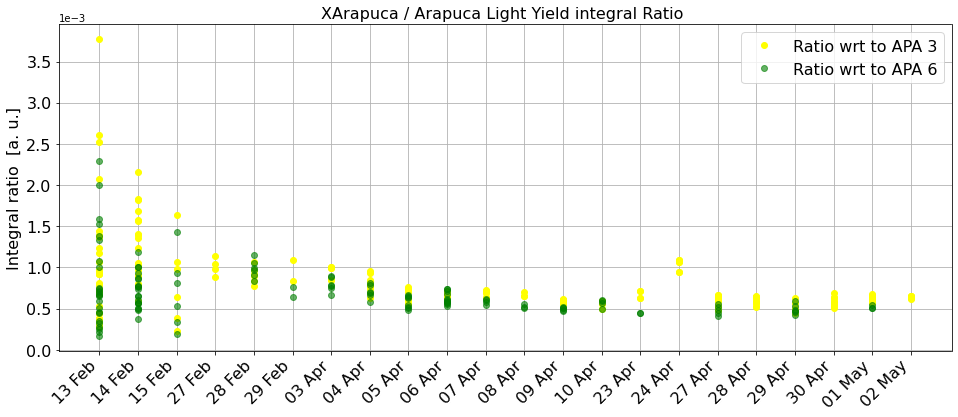

In [149]:
fig = plt.figure(figsize=(16,6))

plt.title('XArapuca / Arapuca Light Yield integral Ratio ', fontsize=16)
plt.errorbar(x=df_XA_vs_APA3['Day/time'], y=df_XA_vs_APA3['W/O quartz']/df_XA_vs_APA3['Integral'], fmt='o', color='yellow', ecolor='lightgray', elinewidth=3, capsize=0, label = 'Ratio wrt to APA 3')

plt.errorbar(x=df_XA_vs_APA6['Day/time'], y=df_XA_vs_APA6['W/O quartz']/df_XA_vs_APA6['Integral'], fmt='o', color='green', ecolor='lightgray', elinewidth=3, capsize=0, alpha = 0.6, label = 'Ratio wrt to APA 6')


plt.ylabel('Integral ratio  [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()
fig.savefig('./ratio_XA-A.pdf')



# Draw some calibrated waveform 

In [150]:
#read APA 6 files 

base_path_wfapa6 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603/wf'
file_path_wfapa6 = os.path.join(base_path_wfapa6,'CalibWaveforms_run*.csv')

file_name_list_wfapa6 =  glob.glob(file_path_wfapa6) 
df_wfapa6 = readfile_list(file_name_list_wfapa6)
df_wfapa6.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_wfapa6.head()

,Run Number,Ch,24,25,26,27,28,29,30,31,...,2018,2019,2020,2021,2022,2023,n good evts,pe area_mean,pe area_std,f_cal
0,10928,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.243512,0.244834,0.244973,0.246203,0.240937,0.240647,2874,436.321425,144.191669,1.000000
1,10928,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.322130,0.323835,0.323785,0.318448,0.310397,0.308591,3214,448.526274,152.212950,1.027972
2,10928,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.302406,0.303317,0.304616,0.301159,0.295146,0.287667,3100,447.871221,145.526538,1.026471
3,10928,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.195350,0.195253,0.193073,0.187683,0.182341,0.182583,2949,407.150835,135.602314,0.933144
4,10928,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.283530,0.278263,0.278416,0.277813,0.275124,0.270162,4587,457.516860,141.059926,1.048578


In [151]:
df_goodwf_apa6 = pd.merge(df_Xerunlist_info, df_wfapa6, how = 'inner', on=['Run Number'])
df_goodwf_apa6.head()

,Run Number,Day/time,daytime,Efield,Ch,24,25,26,27,28,...,2018,2019,2020,2021,2022,2023,n good evts,pe area_mean,pe area_std,f_cal
0,10906,09 Feb,2020-02-09 09:38:25+00:00,False,0,NaN,NaN,NaN,NaN,NaN,...,0.631086,0.628372,0.613897,0.592881,0.576458,0.563445,479,428.637319,143.642488,1.000000
1,10906,09 Feb,2020-02-09 09:38:25+00:00,False,1,NaN,NaN,NaN,NaN,NaN,...,0.661142,0.655411,0.637669,0.624011,0.629194,0.620414,519,451.527191,141.027861,1.053401
2,10906,09 Feb,2020-02-09 09:38:25+00:00,False,2,NaN,NaN,NaN,NaN,NaN,...,0.732403,0.721491,0.720777,0.723505,0.715841,0.713892,504,436.485996,138.851738,1.018311
3,10906,09 Feb,2020-02-09 09:38:25+00:00,False,3,NaN,NaN,NaN,NaN,NaN,...,-0.052078,-0.046592,-0.040659,-0.048272,-0.068870,-0.067974,305,418.461444,151.723009,0.976260
4,10906,09 Feb,2020-02-09 09:38:25+00:00,False,4,NaN,NaN,NaN,NaN,NaN,...,0.617246,0.612814,0.601898,0.591305,0.577686,0.566986,557,474.651273,152.808346,1.107349


In [152]:
df_goodwf_apa6 = df_goodwf_apa6.groupby(['Run Number']).sum().T
df_goodwf_apa6.head()

Run Number,10906,10907,10909,10915,10922,10928,10933,10940,10941,10943,...,11110,11111,11112,11115,11116,11117,11139,11146,11158,11165
Efield,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Ch,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,132,66,66,66
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
# Define doping periods 

col = df_goodwf_apa6.columns

apa6_Xedop_pre = [c for c in col if c <10943]
apa6_Xedop_1 = [c for c in col if (c >=10943) & (c <=10960)]
apa6_Xedop_2 = [c for c in col if (c >11008) & (c < 11101)  ]

apa6_Xedop_3 = [c for c in col if (c >11102) & (c < 11143)  ]
apa6_Xedop_4 = [c for c in col if (c >11145)   ]



In [154]:
df_wfapa6_Xe_pre = df_goodwf_apa6[apa6_Xedop_pre]
df_wfapa6_Xe_dop1 = df_goodwf_apa6[apa6_Xedop_1]
df_wfapa6_Xe_dop2 = df_goodwf_apa6[apa6_Xedop_2]
df_wfapa6_Xe_dop3 = df_goodwf_apa6[apa6_Xedop_3]
df_wfapa6_Xe_dop4 = df_goodwf_apa6[apa6_Xedop_4]

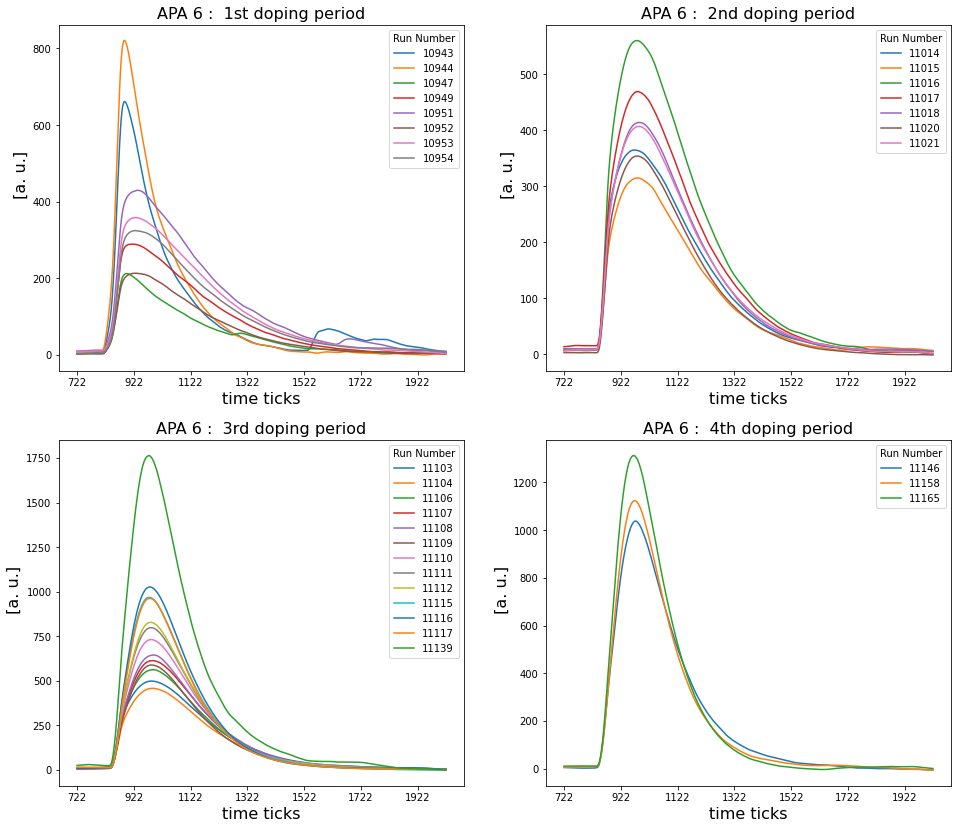

In [155]:
fig = plt.figure(figsize=(16,14))
plt.title('APA 6 : average waveforms', fontsize=16)


ax1=plt.subplot(221)
plt.title('APA 6 :  1st doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop1[700:2000].plot(ax=ax1)


ax2=plt.subplot(222)
plt.title('APA 6 :  2nd doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop2[700:2000].plot(ax=ax2)



ax3=plt.subplot(223)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
plt.title('APA 6 :  3rd doping period', fontsize=16)
df_wfapa6_Xe_dop3[700:2000].plot(ax=ax3)

ax4=plt.subplot(224)
plt.title('APA 6 :  4th doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa6_Xe_dop4[700:2000].plot(ax=ax4)

plt.show()
fig.savefig('./av_wfs_APA6_perdopingperiod.pdf')


,Run Number,Day/time,Efield,Ch,24,25,26,27,28,29,...,2018,2019,2020,2021,2022,2023,n good evts,pe area_mean,pe area_std,f_cal
0,10906,09 Feb,False,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.631086,0.628372,0.613897,0.592881,0.576458,0.563445,479,428.637319,143.642488,1.000000
1,10906,09 Feb,False,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.661142,0.655411,0.637669,0.624011,0.629194,0.620414,519,451.527191,141.027861,1.053401
2,10906,09 Feb,False,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.732403,0.721491,0.720777,0.723505,0.715841,0.713892,504,436.485996,138.851738,1.018311
3,10906,09 Feb,False,3,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.052078,-0.046592,-0.040659,-0.048272,-0.068870,-0.067974,305,418.461444,151.723009,0.976260
4,10906,09 Feb,False,4,NaN,NaN,NaN,NaN,NaN,NaN,...,0.617246,0.612814,0.601898,0.591305,0.577686,0.566986,557,474.651273,152.808346,1.107349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,11165,01 May,False,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.211106,0.201839,0.199596,0.186143,0.179417,0.159387,223,442.315208,116.415214,1.000000
529,11165,01 May,False,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.270882,0.244884,0.245961,0.226886,0.213195,0.193658,207,463.015333,150.044283,1.046799
530,11165,01 May,False,2,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.339055,-0.350639,-0.372341,-0.384364,-0.380845,-0.387150,229,439.085196,153.428550,0.992697
531,11165,01 May,False,3,NaN,NaN,NaN,NaN,NaN,NaN,...,0.312955,0.317190,0.311461,0.317190,0.280576,0.276591,145,408.246556,135.869679,0.922977


## APA 3 

In [156]:
#read APA 3 files 

base_path_wfapa3 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304/wf'
file_path_wfapa3 = os.path.join(base_path_wfapa3,'CalibWaveforms_run*.csv')

file_name_list_wfapa3 =  glob.glob(file_path_wfapa3) 
df_wfapa3 = readfile_list(file_name_list_wfapa3)
df_wfapa3.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_wfapa3.head()

,Run Number,Ch,24,25,26,27,28,29,30,31,...,2018,2019,2020,2021,2022,2023,n good evts,pe area_mean,pe area_std,f_cal
0,10903,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.053257,1.044044,1.031924,1.024351,1.011604,0.996404,2500,479.742961,157.147799,1.000000
1,10903,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.930004,0.923963,0.921665,0.924782,0.919475,0.910667,2763,480.990643,158.020421,1.002601
2,10903,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.260157,-0.260974,-0.256672,-0.256263,-0.259511,-0.255381,1548,480.188428,152.783426,1.000929
3,10903,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.854682,1.846442,1.841040,1.831534,1.819506,1.808836,3115,502.774537,163.942098,1.048008
4,10903,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.690791,0.684948,0.679756,0.676448,0.670439,0.663329,3801,484.567914,161.076343,1.010057


In [157]:
df_goodwf_apa3 = pd.merge(df_Xerunlist_info, df_wfapa3, how = 'inner', on=['Run Number'])
df_goodwf_apa3.head()

,Run Number,Day/time,daytime,Efield,Ch,24,25,26,27,28,...,2018,2019,2020,2021,2022,2023,n good evts,pe area_mean,pe area_std,f_cal
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,0,NaN,NaN,NaN,NaN,NaN,...,0.292631,0.284171,0.276857,0.270907,0.264296,0.257675,3081,489.968068,159.806797,1.000000
1,10877,06 Feb,2020-02-06 16:06:42+00:00,False,1,NaN,NaN,NaN,NaN,NaN,...,1.287621,1.377379,1.475485,1.568502,1.660079,1.759033,3098,472.398410,158.004998,0.964141
2,10877,06 Feb,2020-02-06 16:06:42+00:00,False,2,NaN,NaN,NaN,NaN,NaN,...,0.529557,0.542969,0.560243,0.576848,0.595928,0.615357,3347,488.991947,156.059397,0.998008
3,10877,06 Feb,2020-02-06 16:06:42+00:00,False,3,NaN,NaN,NaN,NaN,NaN,...,0.161501,0.157214,0.154950,0.152204,0.152477,0.150936,2058,494.233581,160.738243,1.008706
4,10877,06 Feb,2020-02-06 16:06:42+00:00,False,4,NaN,NaN,NaN,NaN,NaN,...,0.457186,0.450145,0.450819,0.449599,0.445494,0.440017,2662,482.778255,156.120687,0.985326


In [158]:
df_goodwf_apa3 = df_goodwf_apa3.groupby(['Run Number']).sum().T
df_goodwf_apa3.head()

Run Number,10877,10878,10879,10885,10903,10904,10905,10906,10907,10909,...,11147,11148,11152,11159,11163,11164,11165,11170,11171,11172
Efield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ch,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,...,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
col = df_goodwf_apa3.columns

apa3_Xedop_pre = [c for c in col if c <10943]
apa3_Xedop_1 = [c for c in col if (c >=10943) & (c <=10960)]
apa3_Xedop_2 = [c for c in col if (c >11008) & (c < 11101)  ]

apa3_Xedop_3 = [c for c in col if (c >11102) & (c < 11143)  ]
apa3_Xedop_4 = [c for c in col if (c >11145)   ]


df_wfapa3_Xe_pre = df_goodwf_apa3[apa3_Xedop_pre]
df_wfapa3_Xe_dop1 = df_goodwf_apa3[apa3_Xedop_1]
df_wfapa3_Xe_dop2 = df_goodwf_apa3[apa3_Xedop_2]
df_wfapa3_Xe_dop3 = df_goodwf_apa3[apa3_Xedop_3]
df_wfapa3_Xe_dop4 = df_goodwf_apa3[apa3_Xedop_4]

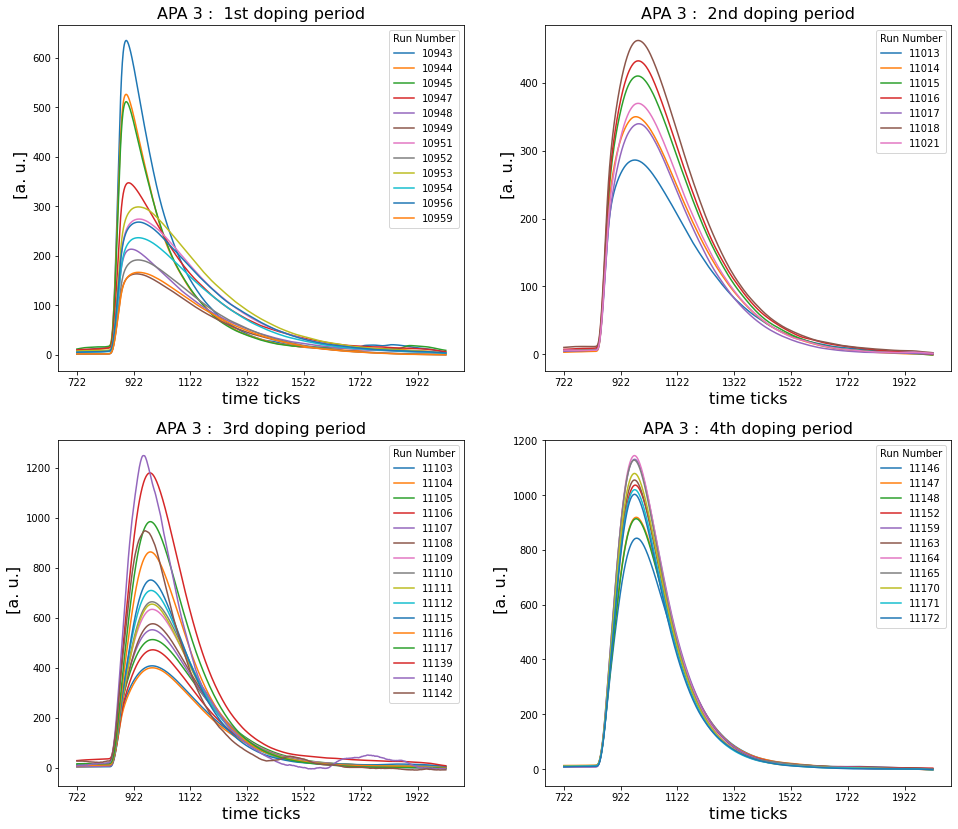

In [160]:
fig = plt.figure(figsize=(16,14))
plt.title('APA 3 : average waveforms', fontsize=16)


ax1=plt.subplot(221)
plt.title('APA 3 :  1st doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16)
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop1[700:2000].plot(ax=ax1)

ax2=plt.subplot(222)
plt.title('APA 3 :  2nd doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16)
plt.ylabel('         [a. u.]', fontsize=16)
df_wfapa3_Xe_dop2[700:2000].plot(ax=ax2)


ax3=plt.subplot(223)
plt.title('APA 3 :  3rd doping period', fontsize=16)
df_wfapa3_Xe_dop3[700:2000].plot(ax=ax3)
plt.xlabel('time ticks', fontsize=16)
plt.ylabel('         [a. u.]', fontsize=16)


ax4=plt.subplot(224)
plt.title('APA 3 :  4th doping period', fontsize=16)
plt.xlabel('time ticks', fontsize=16, ma='right')
plt.ylabel('         [a. u.]', fontsize=16)

#df_goodwf_apa6[apa6_Xedop_4][700:2000].plot()
df_wfapa3_Xe_dop4[700:2000].plot(ax=ax4)

plt.show()
fig.savefig('./av_wfs_APA3_perdopingperiod.pdf')


In [161]:
df_apa3_efieldOFF.head()

,Run Number,Day/time,daytime,Efield,Integral,stat err
0,10877,06 Feb,2020-02-06 16:06:42+00:00,False,143112.006752,167.263266
1,10878,06 Feb,2020-02-06 17:20:49+00:00,False,134258.434941,177.208916
2,10879,06 Feb,2020-02-06 18:27:43+00:00,False,146913.710598,163.000000
3,10885,07 Feb,2020-02-07 10:59:21+00:00,False,138948.518489,142.635900
4,10903,08 Feb,2020-02-08 09:40:06+00:00,False,142025.626576,163.187009


In [162]:
apa3_dop1 = (  df_apa3_efieldOFF['Run Number'] >= 10943)  & ( df_apa3_efieldOFF['Run Number']<=10960) 
apa3_dop2 = (  df_apa3_efieldOFF['Run Number'] > 11008)  & ( df_apa3_efieldOFF['Run Number']<11101) 
apa3_dop3 = (  df_apa3_efieldOFF['Run Number'] > 11102)  & ( df_apa3_efieldOFF['Run Number']<=11143) 
apa3_dop4 = (  df_apa3_efieldOFF['Run Number'] > 11145) 


apa6_dop1 = (  df_apa6_efieldOFF['Run Number'] >= 10952)  & ( df_apa6_efieldOFF['Run Number']<=10960) 
apa6_dop2 = (  df_apa6_efieldOFF['Run Number'] > 11008)  & ( df_apa6_efieldOFF['Run Number']<11101) 
apa6_dop3 = (  df_apa6_efieldOFF['Run Number'] > 11102)  & ( df_apa6_efieldOFF['Run Number']<=11143) 
apa6_dop4 = (  df_apa6_efieldOFF['Run Number'] > 11145) 


apa3_afdop1 = (  df_apa3_efieldOFF['Run Number'] >= 10943)  & ( df_apa3_efieldOFF['Run Number']<=11008) 
apa3_afdop2 = (  df_apa3_efieldOFF['Run Number'] >= 11032)  & ( df_apa3_efieldOFF['Run Number']<11101) 
apa3_afdop3 = (  df_apa3_efieldOFF['Run Number'] >= 11116)  & ( df_apa3_efieldOFF['Run Number']<=11143) 
apa3_afdop4 = (  df_apa3_efieldOFF['Run Number'] > 11164) 

apa6_afdop1 = (  df_apa6_efieldOFF['Run Number'] >= 10943)  & ( df_apa6_efieldOFF['Run Number']<=11008) 
apa6_afdop2 = (  df_apa6_efieldOFF['Run Number'] >= 11032)  & ( df_apa6_efieldOFF['Run Number']<11101) 
apa6_afdop3 = (  df_apa6_efieldOFF['Run Number'] >= 11116)  & ( df_apa6_efieldOFF['Run Number']<=11143) 
apa6_afdop4 = (  df_apa6_efieldOFF['Run Number'] > 11164) 




In [163]:
apa3_int_dop1 = df_apa3_efieldOFF[apa3_dop1]['Integral'].mean()
apa3_int_dop2 = df_apa3_efieldOFF[apa3_dop2]['Integral'].mean()
apa3_int_dop3 = df_apa3_efieldOFF[apa3_dop3]['Integral'].mean()
apa3_int_dop4 = df_apa3_efieldOFF[apa3_dop4]['Integral'].mean()

apa6_int_dop1 = df_apa6_efieldOFF[apa6_dop1]['Integral'].mean()          
apa6_int_dop2 = df_apa6_efieldOFF[apa6_dop2]['Integral'].mean()
apa6_int_dop3 = df_apa6_efieldOFF[apa6_dop3]['Integral'].mean()
apa6_int_dop4 = df_apa6_efieldOFF[apa6_dop4]['Integral'].mean()

apa3_int_afdop1 = df_apa3_efieldOFF[apa3_afdop1]['Integral'].mean()
apa3_int_afdop2 = df_apa3_efieldOFF[apa3_afdop2]['Integral'].mean()
apa3_int_afdop3 = df_apa3_efieldOFF[apa3_afdop3]['Integral'].mean()
apa3_int_afdop4 = df_apa3_efieldOFF[apa3_afdop4]['Integral'].mean()

apa6_int_afdop1 = df_apa6_efieldOFF[apa6_afdop1]['Integral'].mean()          
apa6_int_afdop2 = df_apa6_efieldOFF[apa6_afdop2]['Integral'].mean()
apa6_int_afdop3 = df_apa6_efieldOFF[apa6_afdop3]['Integral'].mean()
apa6_int_afdop4 = df_apa6_efieldOFF[apa6_afdop4]['Integral'].mean()

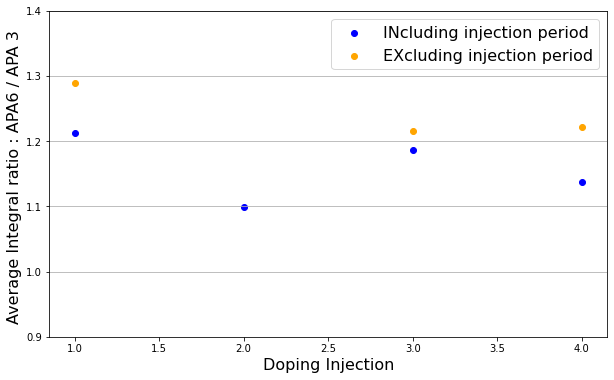

In [164]:
doping = np.arange(1,5)

ratio = np.array([ apa6_int_dop1/apa3_int_dop1 ,
                apa6_int_dop2/apa3_int_dop2,
                apa6_int_dop3/apa3_int_dop3,
                apa6_int_dop4/apa3_int_dop4]
                 )

ratio_af = np.array([ apa6_int_afdop1/apa3_int_afdop1 ,
                apa6_int_afdop2/apa3_int_afdop2,
                apa6_int_afdop3/apa3_int_afdop3,
                apa6_int_afdop4/apa3_int_afdop4]
                 )


fig = plt.figure(figsize=(10,6))
plt.scatter(x=doping, y=ratio, color='blue', label='INcluding injection period')
plt.scatter(x=doping, y=ratio_af, color='orange', label='EXcluding injection period')


plt.ylim(0.9, 1.4)

plt.ylabel('Average Integral ratio : APA6 / APA 3 ' , fontsize = 16)
plt.xlabel('Doping Injection', fontsize = 16)

plt.grid(axis='y')
plt.legend(fontsize=16)
plt.show()

fig.savefig('./av_ratio_overinjectionperiod.pdf')

In [165]:
ratio

array([1.21229595, 1.09822893, 1.18602491, 1.1368932 ])

array([0.80747363, 0.92856524, 0.8555529 , 0.85356536])

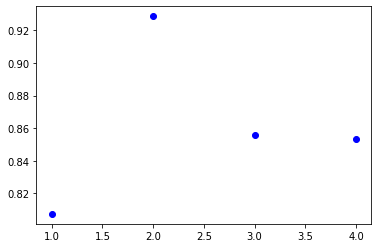

In [182]:
df_ratio_apas

dop1 = (  df_ratio_apas['Run Number'] >= 10943)  & ( df_ratio_apas['Run Number']<=10960) 
dop2 = (  df_ratio_apas['Run Number'] > 11008)  & ( df_ratio_apas['Run Number']<11101) 
dop3 = (  df_ratio_apas['Run Number'] > 11102)  & ( df_ratio_apas['Run Number']<=11143) 
dop4 = (  df_ratio_apas['Run Number'] > 11145) 


apa3_int_dop1 = df_ratio_apas[dop1]['Integral_APA3'].mean()
apa3_int_dop2 = df_ratio_apas[dop2]['Integral_APA3'].mean()
apa3_int_dop3 = df_ratio_apas[dop3]['Integral_APA3'].mean()
apa3_int_dop4 = df_ratio_apas[dop4]['Integral_APA3'].mean()

apa6_int_dop1 = df_ratio_apas[dop1]['Integral_APA6'].mean()          
apa6_int_dop2 = df_ratio_apas[dop2]['Integral_APA6'].mean()
apa6_int_dop3 = df_ratio_apas[dop3]['Integral_APA6'].mean()
apa6_int_dop4 = df_ratio_apas[dop4]['Integral_APA6'].mean()



doping2 = np.arange(1,5)

ratio2 = np.array([ apa3_int_dop1/apa6_int_dop1 ,
                apa3_int_dop2/apa6_int_dop2,
                apa3_int_dop3/apa6_int_dop3,
                apa3_int_dop4/apa6_int_dop4]
                 )

plt.scatter(x=doping2, y=ratio2, color='blue')
ratio2

In [141]:
apa6_dop3.head()

NameError: name 'apa6_dop3' is not defined

In [113]:


### check missing runs for both APA 3 and APA 6
df_runlist = df_Xerunlist[['Run Number', 'Day/time','Efield']]
df_runlist.head()

,Run Number,Day/time,Efield
0,10872,06/02/2020,False
1,10873,06/02/2020,False
2,10874,06/02/2020,False
3,10875,06/02/2020,False
4,10877,06/02/2020,False


In [129]:
#APA 3 runs available
df_integral_304.head()


,Run Number,Integral,stat err
0,10877,143112.006752,167.263266
1,10878,134258.434941,177.208916
2,10879,146913.710598,163.000000
3,10885,138948.518489,142.635900
4,10903,142025.626576,163.187009


In [166]:
#df_apa3_status = df_runlist.join(df_integral_304, on='Run Number', how='left', lsuffix='_list', rsuffix='_apa' )
df_apa3_status = pd.merge(df_runlist, df_integral_304, how='left', on=['Run Number'])
df_apa3_status.head(100)

,Run Number,Day/time,Efield,Integral,stat err
0,10872,06/02/2020,False,NaN,NaN
1,10873,06/02/2020,False,NaN,NaN
2,10874,06/02/2020,False,NaN,NaN
3,10875,06/02/2020,False,NaN,NaN
4,10877,06/02/2020,False,143112.006752,167.263266
...,...,...,...,...,...
95,11172,02/05/2020,False,231681.303300,183.191157
96,11173,03/05/2020,False,NaN,NaN
97,11174,04/05/2020,False,NaN,NaN
98,11184,04/05/2020,False,NaN,NaN


In [139]:
df_apa3_status.loc[(df_apa3_status['Efield']==False) & (df_apa3_status['Integral'].isnull()) ]['Run Number']

0     10872
1     10873
2     10874
3     10875
26    10950
33    10960
45    11020
47    11022
57    11092
62    11101
77    11118
86    11149
88    11158
96    11173
97    11174
98    11184
Name: Run Number, dtype: int64

In [169]:
df_apa3_status.loc[(df_apa3_status['Run Number']>11018) & (df_apa3_status['Run Number']<= 11022) ]

,Run Number,Day/time,Efield,Integral,stat err
45,11020,01/03/2020,False,NaN,NaN
46,11021,02/03/2020,False,130891.243951,311.462678
47,11022,02/03/2020,False,NaN,NaN


In [116]:
#APA 6 run available

df_integral_603.head()

,Run Number,Integral,stat err
0,10906,117264.588563,80.901174
1,10907,136793.434553,125.582642
2,10909,127661.812705,76.111760
3,10912,169646.176015,52.640289
4,10915,167335.857995,54.304696
